In [135]:
from google.colab import files
uploaded = files.upload()


Saving COMED_hourly.csv to COMED_hourly (1).csv


In [0]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import sklearn.preprocessing
import tensorflow as tf
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

%matplotlib inline

df = pd.read_csv(io.BytesIO(uploaded['COMED_hourly.csv']), index_col=[0], parse_dates=[0])


df['dow'] = df.index.dayofweek
df['doy'] = df.index.dayofyear
df['year'] = df.index.year
df['month'] = df.index.month 
df['quarter'] = df.index.quarter
df['hour'] = df.index.hour 
df['woy'] = df.index.weekofyear
df['dom'] = df.index.day
df['season'] = df['month'].apply(lambda month_number: (month_number%12 + 3)//3)
df = df.rename(columns={'COMED_MW':'Usage'})



In [137]:
df.head()

,Usage,dow,doy,year,month,quarter,hour,woy,dom,season
Datetime,,,,,,,,,,
2011-12-31 01:00:00,9970.0,5,365,2011,12,4,1,52,31,1
2011-12-31 02:00:00,9428.0,5,365,2011,12,4,2,52,31,1
2011-12-31 03:00:00,9059.0,5,365,2011,12,4,3,52,31,1
2011-12-31 04:00:00,8817.0,5,365,2011,12,4,4,52,31,1
2011-12-31 05:00:00,8743.0,5,365,2011,12,4,5,52,31,1


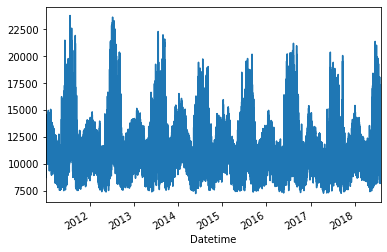

In [138]:
df['Usage'].plot()

In [150]:
df = df.dropna()
df.describe

<bound method NDFrame.describe of                        Usage  dow  doy  year  ...  hour  woy  dom  season
Datetime                                      ...                        
2011-12-31 01:00:00   9970.0    5  365  2011  ...     1   52   31       1
2011-12-31 02:00:00   9428.0    5  365  2011  ...     2   52   31       1
2011-12-31 03:00:00   9059.0    5  365  2011  ...     3   52   31       1
2011-12-31 04:00:00   8817.0    5  365  2011  ...     4   52   31       1
2011-12-31 05:00:00   8743.0    5  365  2011  ...     5   52   31       1
...                      ...  ...  ...   ...  ...   ...  ...  ...     ...
2018-01-01 20:00:00  13858.0    0    1  2018  ...    20    1    1       1
2018-01-01 21:00:00  13758.0    0    1  2018  ...    21    1    1       1
2018-01-01 22:00:00  13627.0    0    1  2018  ...    22    1    1       1
2018-01-01 23:00:00  13336.0    0    1  2018  ...    23    1    1       1
2018-01-02 00:00:00  12816.0    1    2  2018  ...     0    1    2       1

[66

Split data into train/test sets

In [151]:
cutoff = pd.to_datetime('2017-01-01')

# splitting
train = df.loc[df.index <= cutoff].copy()
test = df.loc[df.index > cutoff].copy()
print(f'Training shape: {train.shape} \nTesting shape: {test.shape}\n')
print(f'The training set lies between the dates: {min(train.index)} and {max(train.index)}')
print(f'For the testing set, the dates are: {min(test.index)} and {max(test.index)}')

Training shape: (52602, 10) 
Testing shape: (13895, 10)

The training set lies between the dates: 2011-01-01 01:00:00 and 2017-01-01 00:00:00
For the testing set, the dates are: 2017-01-01 01:00:00 and 2018-08-03 00:00:00


In [0]:
def create_features(df, label=None):
  x = df[['Usage','dow', 'doy', 'year', 'month', 'quarter', 'hour', 'woy', 'dom', 'season']]
  if label:
    y = df[label]
    return x,y
  return x

x_train, y_train = create_features(train, label='Usage')
x_test, y_test = create_features(test, label='Usage')

First Model: XGBoost

In [155]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
reg = xgb.XGBRegressor(n_estimators=5000)
reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], early_stopping_rounds=50, verbose=False)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[21:54:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=5000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

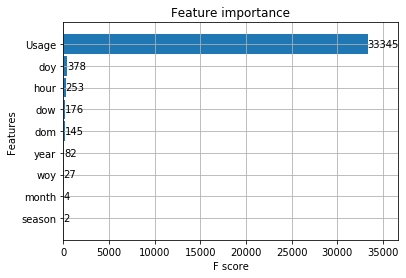

In [156]:
_ = plot_importance(reg, height=0.9)

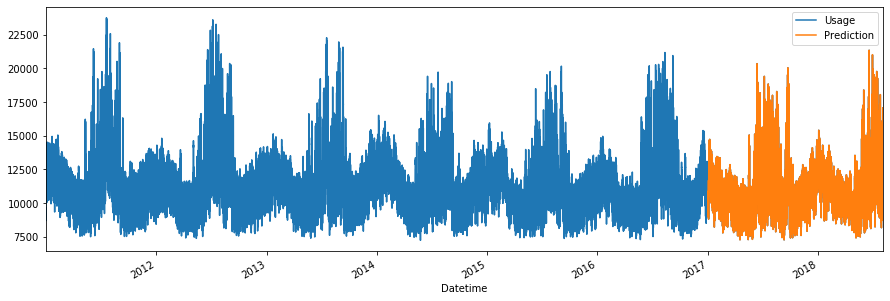

In [157]:
test['Prediction'] = reg.predict(x_test)
full_df = pd.concat([test, train], sort=False)
_ = full_df[['Usage', 'Prediction']].plot(figsize=(15,5))

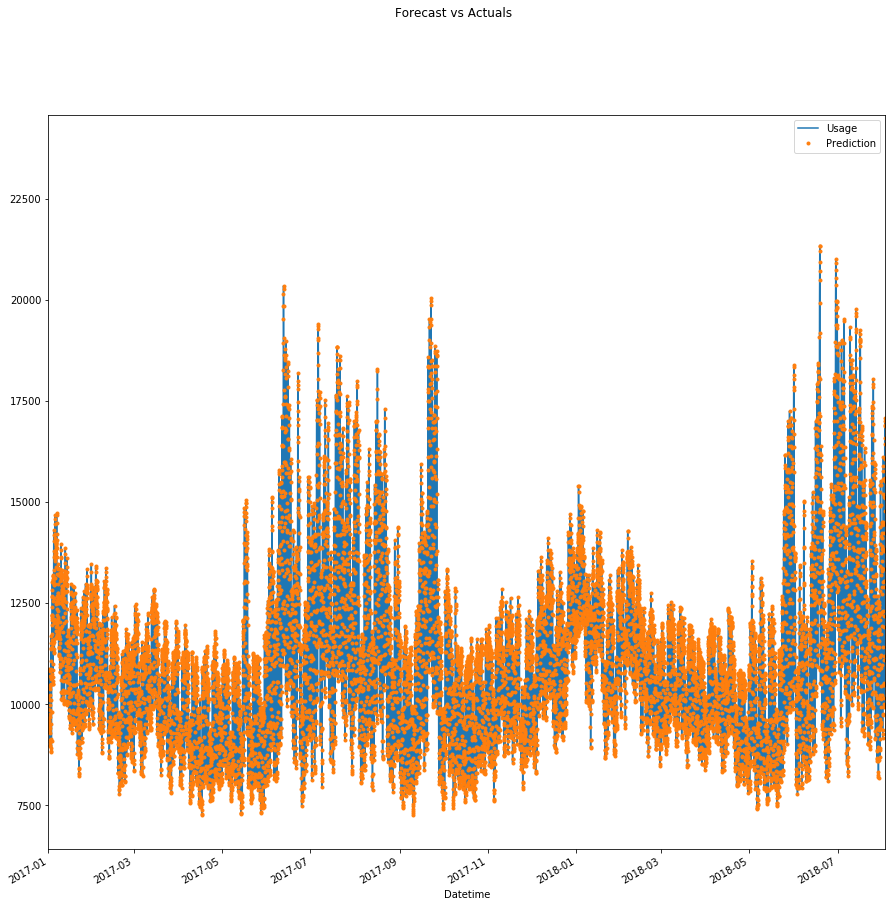

In [158]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(15)
f.set_figwidth(15)
_ = full_df[['Usage','Prediction']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='2017-01-01', upper='2018-08-03')

plot = plt.suptitle('Forecast vs Actuals')

In [159]:
mean_squared_error(y_true=test['Usage'],
                   y_pred=test['Prediction'])

0.9983983794662239

In [160]:
mean_absolute_error(y_true=test['Usage'],
                   y_pred=test['Prediction'])

0.6038447887616949

In [162]:
from google.colab import files
uploaded = files.upload()

Saving FE_hourly.csv to FE_hourly (1).csv


In [165]:
df = pd.read_csv(io.BytesIO(uploaded['FE_hourly.csv']), index_col=[0], parse_dates=[0])
df['dow'] = df.index.dayofweek
df['doy'] = df.index.dayofyear
df['year'] = df.index.year
df['month'] = df.index.month 
df['quarter'] = df.index.quarter
df['hour'] = df.index.hour 
df['woy'] = df.index.weekofyear
df['dom'] = df.index.day
df['season'] = df['month'].apply(lambda month_number: (month_number%12 + 3)//3)
df = df.rename(columns={'FE_MW':'Usage'})
df['Logdiff_Usage'] = np.log(df['Usage']) - np.log(df['Usage']).shift()
df['Log_Usage'] = np.log(df['Usage'])
cutoff = pd.to_datetime('2017-01-01')
df = df.dropna()
# splitting
train = df.loc[df.index <= cutoff].copy()
test = df.loc[df.index > cutoff].copy()
print(f'Training shape: {train.shape} \nTesting shape: {test.shape}\n')
print(f'The training set lies between the dates: {min(train.index)} and {max(train.index)}')
print(f'For the testing set, the dates are: {min(test.index)} and {max(test.index)}')

def create_features(df, label=None):
  x = df[['Usage', 'dow', 'doy', 'year', 'month', 'quarter', 'hour', 'woy', 'dom', 'season']]
  if label:
    y = df[label]
    return x,y
  return x

x_train, y_train = create_features(train, label='Usage')
x_test, y_test = create_features(test, label='Usage')



/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning:

divide by zero encountered in log



Training shape: (48978, 12) 
Testing shape: (13895, 12)

The training set lies between the dates: 2011-06-01 01:00:00 and 2017-01-01 00:00:00
For the testing set, the dates are: 2017-01-01 01:00:00 and 2018-08-03 00:00:00


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[22:00:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


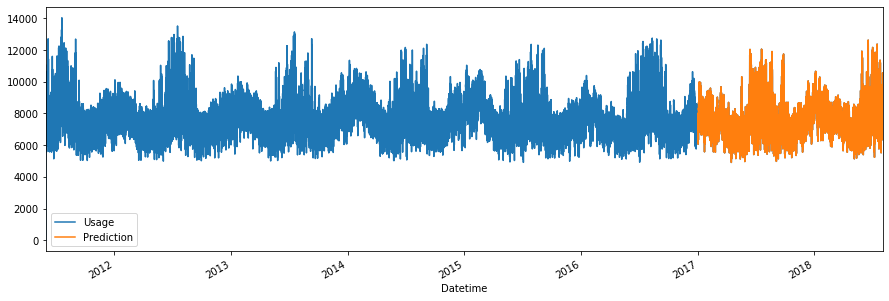

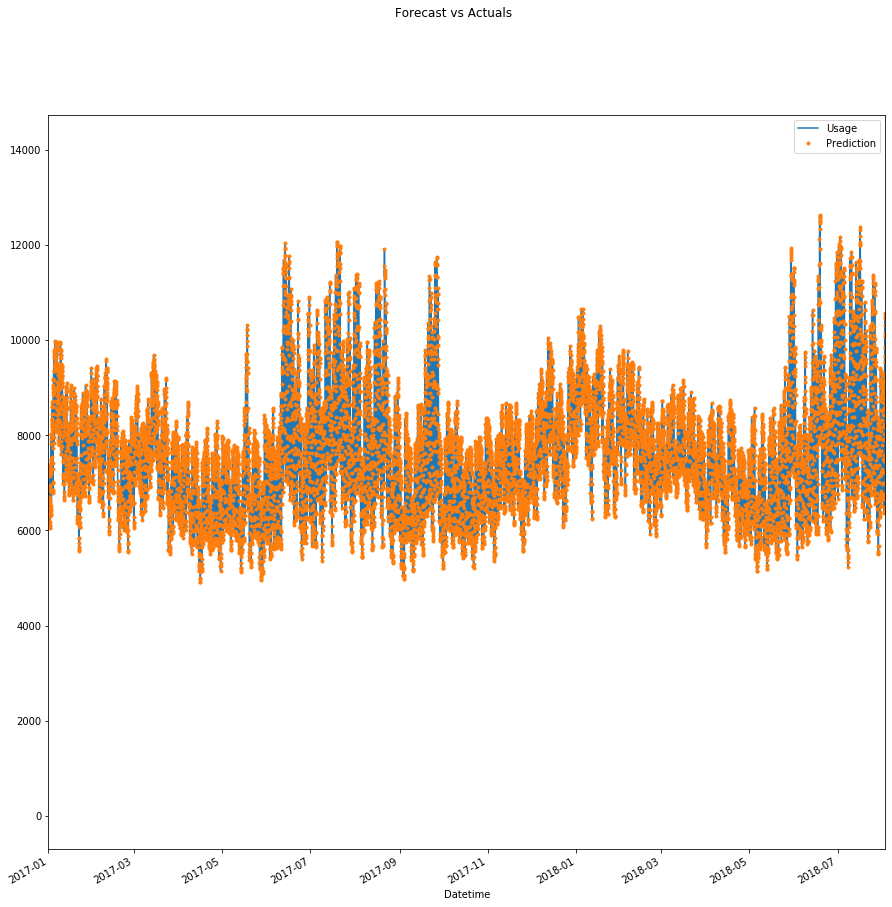

In [169]:
reg = xgb.XGBRegressor(n_estimators=5000)
reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], early_stopping_rounds=50, verbose=False)
test['Prediction'] = reg.predict(x_test)
full_df = pd.concat([test, train], sort=False)
_ = full_df[['Usage', 'Prediction']].plot(figsize=(15,5))
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(15)
f.set_figwidth(15)
_ = full_df[['Usage','Prediction']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='2017-01-01', upper='2018-08-03')
plot = plt.suptitle('Forecast vs Actuals')

In [172]:
mean_squared_error(y_true=test['Usage'],
                   y_pred=test['Prediction'])

0.3429348280722394

In [173]:
mean_absolute_error(y_true=test['Usage'],
                   y_pred=test['Prediction'])

0.3488523370029687